# Validation Metrics research
_By Eli Brouwers_

In this notebook, we will be exploring a way to validate answers given by our multi-model Question-Answering setup for the Text-To-Case project. To do this, we will import our dataset and run it through the multi-model. Then, we will extract a few features, which we call 'validation metrics'. Then, we will train a model that takes in these metrics and tries to predict if an answer should be used or not. Finally, we will evaluate the performance of this model.

# Importing libraries and models

In [1]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import plotly.express as px
import numpy as np
import pandas as pd
import re

We will use the following models:
- deepset/deberta-v3-large-squad2
- deepset/bert-large-uncased-whole-word-masking-squad2
- deepset/bert-base-cased-squad2

In [3]:
model_names = {
    "deberta": "deepset/deberta-v3-large-squad2",
    "bert_large_deepset": "deepset/bert-large-uncased-whole-word-masking-squad2",
    "bert_base": "deepset/bert-base-cased-squad2",
}

models = {}
for model_name in model_names:
    models[model_name] = pipeline("question-answering", model=model_names[model_name], tokenizer=model_names[model_name])

# Importing the data

We start by importing the excell files and doing some cleaning.

In [4]:
df = pd.read_excel('./data/Example forms.xlsx', sheet_name='Lunch_Extractive', dtype=str)

df_melted = df.melt(id_vars='Full story', var_name='question', value_name='answer')
df_melted.columns = ['context', 'question', 'answer']
# replace '?' with '' in answer
df_melted['answer'] = df_melted['answer'].str.replace('?', '')
df = df_melted

C:\Users\elibr\AppData\Local\Temp\ipykernel_14764\146949446.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_melted['answer'] = df_melted['answer'].str.replace('?', '')


Next, we declare a function that runs the dataset through the models and returns a dataframe with the answers and their scores.

In [5]:
# Run questions through models
def generate_predictions(models, dataset):
    results = pd.DataFrame()
    index = 0
    for model in models:
        for row in dataset.iterrows():
            prediction = models[model](context=row[1]['context'], question=row[1]['question'])
            new_row = pd.DataFrame({
                'context': row[1]['context'], 
                'question': row[1]['question'], 
                'answer': row[1]['answer'], 
                'model': model, 
                'prediction': prediction['answer'], 
                'model_confidence': prediction['score']
            }, index=[index])
            results = pd.concat([results, new_row])
            index += 1
    return results

Next, we use a similarity model to encode the answers that the three models gave. We use these vectors for selecting the best answer and calculating the validation metrics. For more information on how we select the best answer, see our Question Answering notebook/research.

In [6]:
similarity_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
def average_answer(dataset): # only answers for a single question
    # get all embeddings from similarity model
    vector_embeddings = {}
    for index, row in dataset.iterrows():
        model_name = row['model']
        vector_embeddings[model_name] = similarity_model.encode(row["prediction"])
    # calculate average vector
    average_vector = np.average(list(vector_embeddings.values()), axis=0)

    # Return answer closest to average
    closest_to_average = max(vector_embeddings, key=lambda key: util.pytorch_cos_sim(average_vector, vector_embeddings[key]))
    row_closest_to_average = dataset[dataset['model'] == closest_to_average]
    return row_closest_to_average

questions = df['question'].unique()
contexts = df['context'].unique()

# Validation Metrics
Now, we get to the validation metrics. We will use the embedding vectors and confidence scores to calculate six metrics:
- Final answer distance to average answer
- Mean distances to average answer
- Mean distance between answers
- Mean confidence score
- Confidence of final answer
- Count of exact matches

Let us go through these one by one.

## Final answer distance to average answer
This metric calculates the distance between the final answer and the average answer. This is done by calculating the cosine similarity between the two vectors. A higher score means that the final answer is closer to the average answer. This says something about the consistency of the answers given by the models.

## Mean distances to average answer
This metric calculates the mean distance between the answers given by the models and the average answer using cosine similarity. A higher score means that the answers given by the models are closer to the average answer. This says something about the 'dividedness' of the models. If the mean is low, this means the models gave very different answers compared to the average answer. This means that the average answer is not a good representation of the answers given by the models.

## Mean distance between answers
This metric calculates the mean distance between the answers given by the models. A higher score means that the answers given by the models are closer to each other. This says something about the 'dividedness' of the models. If the mean is low, this means the models gave very different answers compared to each other. If the models give very different answers, this likely means that the question is not answerable or hard to answer.

## Mean confidence score
This metric calculates the mean confidence score of all the models. A higher score means the models are more confident in their answers. A low score means that the models were not confident, which is likely because the question is not answerable or hard to answer.

## Confidence of final answer
This metric is the confidence of the model that gave the final answer. This is taken as an extra metric because in the case that this model had an outlier confidence score, that might not be reflected in the mean confidence score.

## Count of exact matches
This metric counts the number of exact matches between the answers given by the models. If many models give the same answers, that likely means that the question is easy to answer or easy to confuse.

In [7]:
def answer_form(context, question, expected_answer, models):
    return_data = pd.DataFrame({"context": [context], "question": [question], "expected_answer": [expected_answer]})
    # get answer from each model
    answers = generate_predictions(models, pd.DataFrame({'context': [context], 'question': [question], 'answer': [expected_answer]}))
    # get embedding for each answer
    vector_embeddings = {}
    for index, row in answers.iterrows():
        model_name = row['model']
        vector_embeddings[model_name] = similarity_model.encode(row["prediction"])
    
    # get average answer
    var_average_answer = average_answer(answers)
    return_data['average_answer'] = var_average_answer['prediction'].values[0]
    average_answer_model = var_average_answer['model'].values[0]
    return_data['average_answer_model'] = average_answer_model

    #
    # Metrics
    #

    # final answer distance to average
    average_vector = np.average(list(vector_embeddings.values()), axis=0)
    return_data['final_answer_distance_to_average'] = util.pytorch_cos_sim(average_vector, vector_embeddings[average_answer_model]).item()
    
    # mean all distances to average
    return_data['mean_all_distances_to_average'] = np.mean([util.pytorch_cos_sim(average_vector, vector_embeddings[model]).item() for model in vector_embeddings]).item()

    # mean distance between all answers
    return_data['mean_distance_between_all_answers'] = np.mean([util.pytorch_cos_sim(vector_embeddings[model1], vector_embeddings[model2]).item() for model1 in vector_embeddings for model2 in vector_embeddings if model1 != model2]).item()

    # mean confidence
    return_data['mean_confidence'] = np.mean([row['model_confidence'] for index, row in answers.iterrows()]).item()

    # confidence of final answer
    return_data['confidence_of_final_answer'] = answers[answers['model'] == average_answer_model]['model_confidence'].values[0]
    
    # count of models that returned the same answer
    return_data['count_of_models_that_returned_the_same_answer'] = len(answers[answers['prediction'] == return_data['average_answer'].values[0]])
    

    #
    # Target: similarity of final answer to expected answer
    #
    return_data['similarity_of_final_answer_to_expected_answer'] = util.pytorch_cos_sim(similarity_model.encode(return_data['average_answer'].values[0]), similarity_model.encode(return_data['expected_answer'].values[0])).item()
    
    return return_data

df_all_metrics = pd.DataFrame()
for context in contexts:
    for question in questions:
        df_all_metrics = pd.concat([df_all_metrics, answer_form(context, question, df.loc[(df['context'] == context) & (df['question'] == question), 'answer'].values[0], models)])

df_all_metrics.head()

,context,question,expected_answer,average_answer,average_answer_model,final_answer_distance_to_average,mean_all_distances_to_average,mean_distance_between_all_answers,mean_confidence,confidence_of_final_answer,count_of_models_that_returned_the_same_answer,similarity_of_final_answer_to_expected_answer
0,I would like to arrange a lunch on March 24 in...,How many people are coming?,25 to 30,25 to 30,deberta,0.983956,0.967362,0.903685,0.422513,3.808479e-01,1,1.000000
0,I would like to arrange a lunch on March 24 in...,Who is the organizer?,,25 to 30,bert_base,0.623744,0.617268,0.071530,0.017748,1.690518e-03,1,0.010297
0,I would like to arrange a lunch on March 24 in...,What is the budget?,,25 to 30,deberta,0.903877,0.775137,0.401256,0.059899,1.276783e-07,1,0.010297
0,I would like to arrange a lunch on March 24 in...,What is the date?,March 24,March 24,deberta,1.000000,1.000000,1.000000,0.891966,9.884323e-01,1,1.000000
0,I would like to arrange a lunch on March 24 in...,What is the start time?,12:30,12:30,bert_large_deepset,0.996271,0.992514,0.977627,0.750143,8.131435e-01,2,1.000000


Investigating the metrics with a correlation matrix, we see that the first three features are highly correlated. This makes sense, as they all measure the distances between the answers. We will still use them however, because we do not have a lot of features and data.

<Axes: >

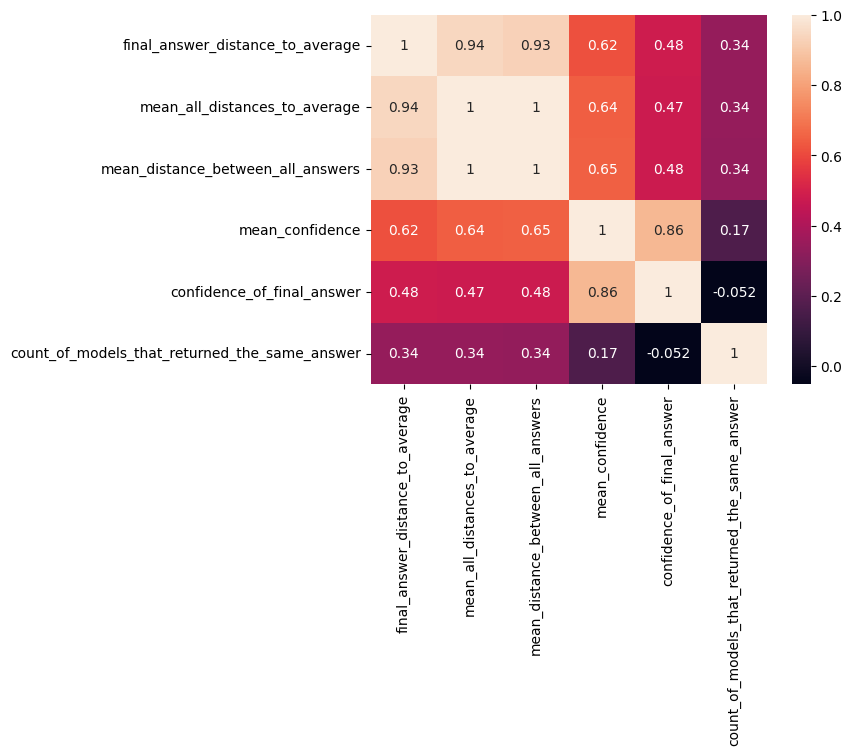

In [12]:
# correlation matrix
import seaborn as sns

sns.heatmap(metrics.corr(), annot=True)

# Data preparation
Before we can continue, we need to prepare the data to train the model on. For each answer given, we have also recorded the validation metrics. We now need to grade the answers given by the multi-model on whether the answer should be accepted or rejected.
First, we set all the answers that are supposed to be unanswerable to rejected. Then, we set all the answers that are an exact match to the expected answer to accepted. Lastly, we prompt the user to grade the remaining answers. We save this data to a csv file as well.

In [3]:
load_from_file = True
if load_from_file:
    df_all_metrics = pd.read_csv('df_all_metrics.csv')
    # # set empty expected answers to empty string
    # df_all_metrics['expected_answer'] = df_all_metrics['expected_answer'].fillna('')
else:
    # Define a function to clean the answers (remove all but the letters and numbers, and convert to lowercase)
    def clean_answer(answer):
        regex = re.compile('[^a-zA-Z0-9]')
        answer = regex.sub('', answer)
        answer = answer.lower()
        return answer

    # Clean the expected_answer and average_answer columns
    df_all_metrics['clean_expected_answer'] = df_all_metrics['expected_answer'].apply(clean_answer)
    df_all_metrics['clean_average_answer'] = df_all_metrics['average_answer'].apply(clean_answer)

    # Create a new column to store the final answer (use_final_answer)
    df_all_metrics['use_final_answer'] = np.nan

    # Set the value of use_final_answer based on whether the clean_expected_answer and clean_average_answer match
    df_all_metrics.loc[df_all_metrics['clean_expected_answer'] == df_all_metrics['clean_average_answer'], 'use_final_answer'] = True

    # Set the value of use_final_answer to False for any rows where expected_answer is blank
    df_all_metrics.loc[df_all_metrics['expected_answer'] == '', 'use_final_answer'] = False

    # For any remaining rows where use_final_answer is still NaN, prompt the user for input
    null_rows = df_all_metrics[df_all_metrics['use_final_answer'].isnull()]
    num_remaining = len(null_rows)

    def prompt_user(row):
        use_final_answer = input(f"Context: {row['context']}, question: {row['question']}, final answer: {row['average_answer']}, expected answer: {row['expected_answer']}, use final answer? (y/n)")
        if use_final_answer.lower() == 'y':
            return True
        else:
            return False

    df_all_metrics.loc[df_all_metrics['use_final_answer'].isnull(), 'use_final_answer'] = null_rows.apply(prompt_user, axis=1)

    # Remove the clean_expected_answer and clean_average_answer columns
    df_all_metrics.drop(['clean_expected_answer', 'clean_average_answer'], axis=1, inplace=True)

    # save to csv
    df_all_metrics.to_csv('df_all_metrics.csv', index=False)

Next, we inspect the balancing of the dataset.

In [4]:
# print ratio of final answers used
print(f"Final answers used: {df_all_metrics['use_final_answer'].sum() / len(df_all_metrics)}")

Final answers used: 0.7395833333333334


We can see that about 74% of the answers are accepted currently. This means the dataset is not balanced and we should take this into account when training the model.

Using T-SNE, we can visualize the data. We can use this to see if the data is separable. If it is not, we might have to use a more complex model.

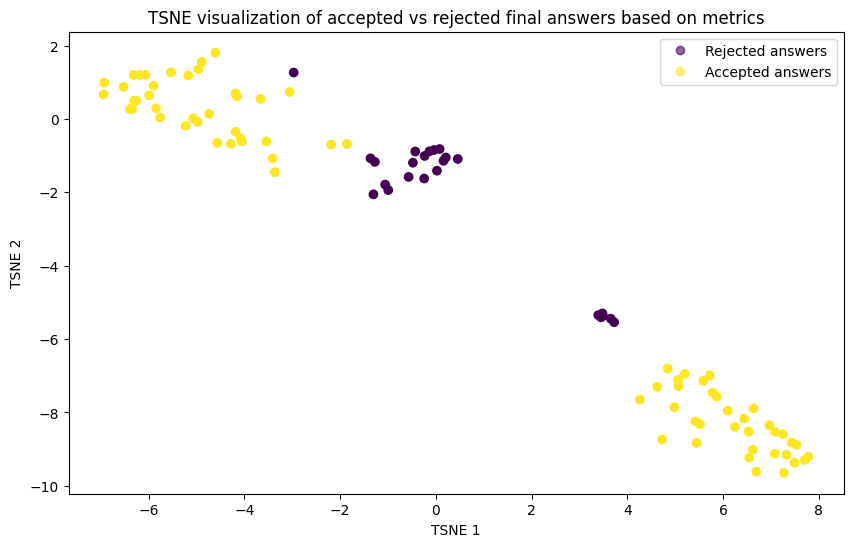

In [16]:
# tsne visualization
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

# get all metrics
metrics = df_all_metrics.drop(['context', 'question', 'expected_answer', 'average_answer', 'average_answer_model', 'use_final_answer'], axis=1)

# get tsne
tsne = TSNE(n_components=2, random_state=1)

# get tsne values
tsne_values = tsne.fit_transform(metrics)

# plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_values[:, 0], tsne_values[:, 1], c=df_all_metrics['use_final_answer'])
plt.title('TSNE visualization of accepted vs rejected final answers based on metrics')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, ['Rejected answers', 'Accepted answers'])
plt.show()

We can see that there are some clusters and it seems like the data is separable. We will continue with training the model.

# Training the model
## Random Forest
We will start by training a Random Forest model. We split the data and train a random forest model on the training data. We then evaluate the model on the test data.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

X = df_all_metrics[['final_answer_distance_to_average', 'mean_all_distances_to_average', 'mean_distance_between_all_answers', 'mean_confidence', 'confidence_of_final_answer', 'count_of_models_that_returned_the_same_answer']]
y = df_all_metrics['use_final_answer']
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weight = {0: 1, 1: 2}

clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0, class_weight=class_weight)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred))

0.8333333333333334


The model got an precision of 0.83. Now, we will look at the confusion matrix to see how the model performed.

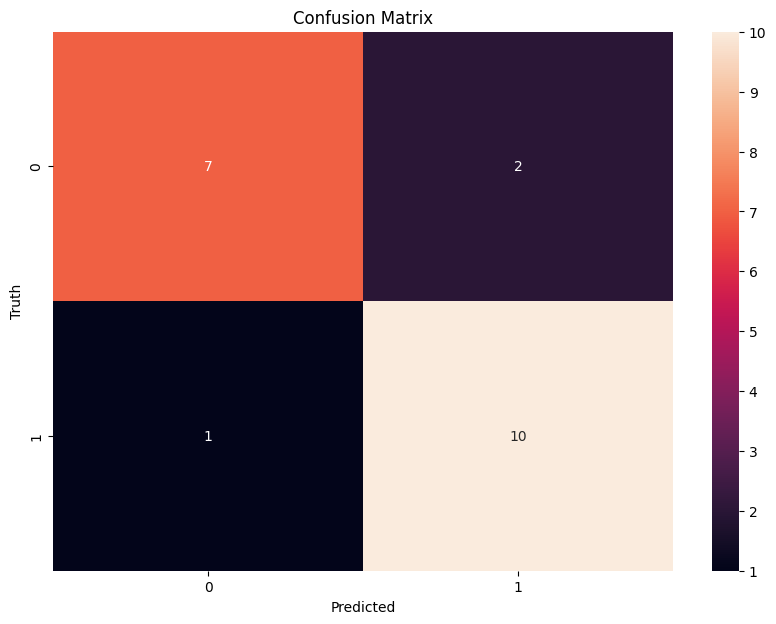

In [23]:
# seaborn confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

This result appears pretty good. We have two false positives. This means the model marked an answer as correct even though it should not. We want to avoid this.

Although the answers of this model are fairly good, it is not adjustable. We want to have some level of control on how many false positives we get. We will try to achieve this by using a neural network.

## Neural Network
We use Keras to train a neural network. The model has 2 outputs with softmax, which predicts the probability of the answer being accepted or rejected.

In [24]:
# try to train simple keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

retrain = False
if retrain:
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

    early_stopping = keras.callbacks.EarlyStopping(
        restore_best_weights=True,
        monitor='val_loss',
        patience=10,
        verbose=1
    )

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.RMSprop(0.001),
                metrics=['accuracy']
                )

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

else:
    model = keras.models.load_model('trust_model.keras')


Training the model for 69 epochs, we get an accuracy of 87.5% on the test data. Let us look at the predictions of the model with a confusion matrix.

In [25]:
# save 
model.save('trust_model.keras', save_format='keras')

## Validation

1/1 [==============================] - 5s 5s/step


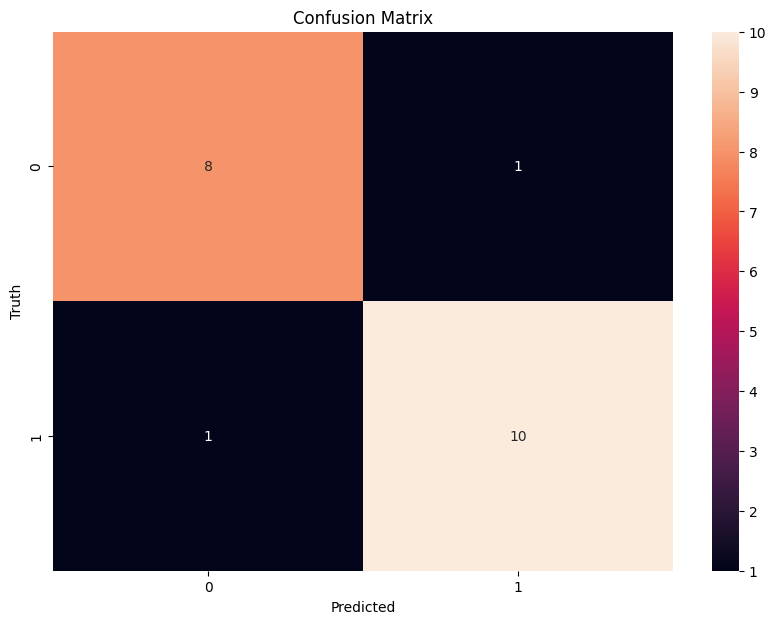

In [26]:
# confusion matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

From this confusion matrix, we can see very similar results to the Random Forest model. We have 1 false positive and 1 false negative. However, this time, we have confidence scores for the predictions. We can use these to adjust the model to our liking. Let us look at the confidence scores for correct and incorrect predictions.

3/3 [==============================] - 0s 4ms/step


C:\Users\elibr\AppData\Local\Temp\ipykernel_5332\1188836605.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrong_answers['highest_confidence'] = df_wrong_answers[['confidence_0', 'confidence_1']].max(axis=1)
C:\Users\elibr\AppData\Local\Temp\ipykernel_5332\1188836605.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct_answers['highest_confidence'] = df_correct_answers[['confidence_0', 'confidence_1']].max(axis=1)


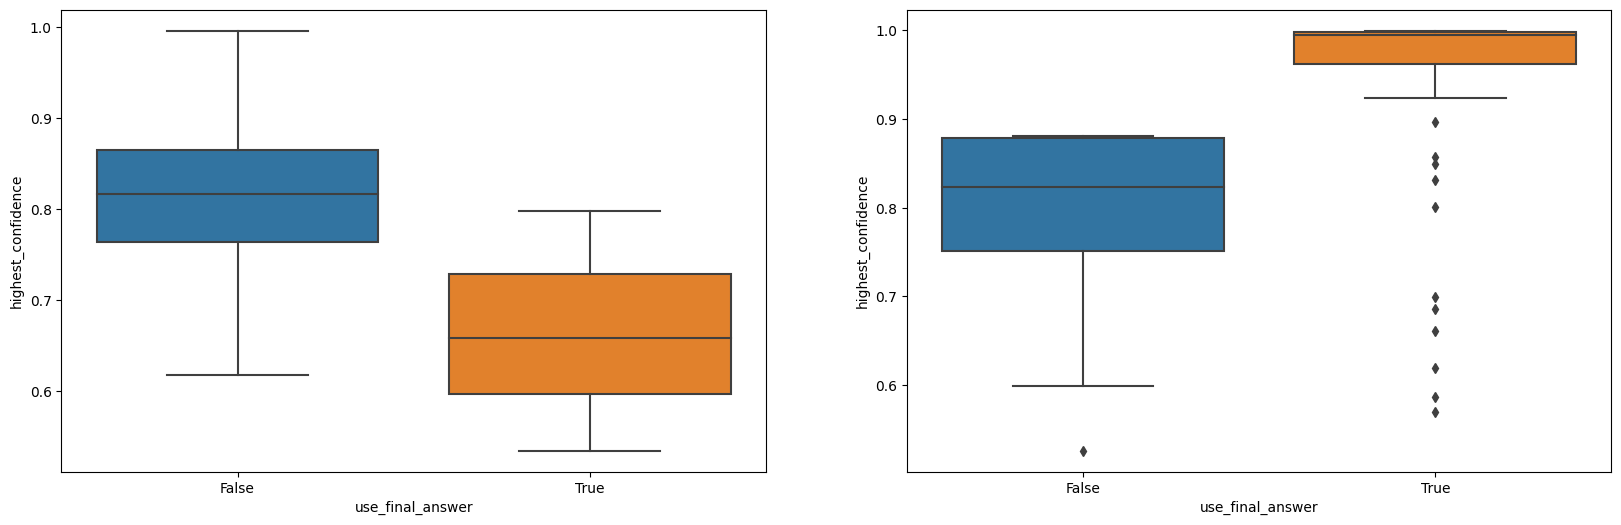

In [27]:
# run all through model
y_pred = model.predict(X)

df_all_metrics['predicted_use_final_answer'] = np.argmax(y_pred, axis=1)

# add row with confidence 0 and confidence 1
df_all_metrics['confidence_0'] = y_pred[:, 0]
df_all_metrics['confidence_1'] = y_pred[:, 1]

# box plots of confidences for wrong and correct answers
df_wrong_answers = df_all_metrics[df_all_metrics['use_final_answer'] != df_all_metrics['predicted_use_final_answer']]
df_wrong_answers['highest_confidence'] = df_wrong_answers[['confidence_0', 'confidence_1']].max(axis=1)
df_correct_answers = df_all_metrics[df_all_metrics['use_final_answer'] == df_all_metrics['predicted_use_final_answer']]
df_correct_answers['highest_confidence'] = df_correct_answers[['confidence_0', 'confidence_1']].max(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(x='use_final_answer', y='highest_confidence', data=df_wrong_answers, ax=ax[0])
sns.boxplot(x='use_final_answer', y='highest_confidence', data=df_correct_answers, ax=ax[1])
plt.show()


On the left, we see the confidence scores for the incorrect predictions. On the right, we see the confidence scores for the correct predictions. We can see that for correct answers, the model is much more confident. Most of the answers give a confidence score of above 90% for True answers, whereas for wrong answers, they all lie below 80%. This means we can likely draw a line at a confidence score to reduce the number of false positives. E.g. if the model gives a 85% confidence score or higher that the answer should be accepted, we can accept it. Everything below that, we reject, because it is likely a false positive. Let us try this.

0.4800000000000003


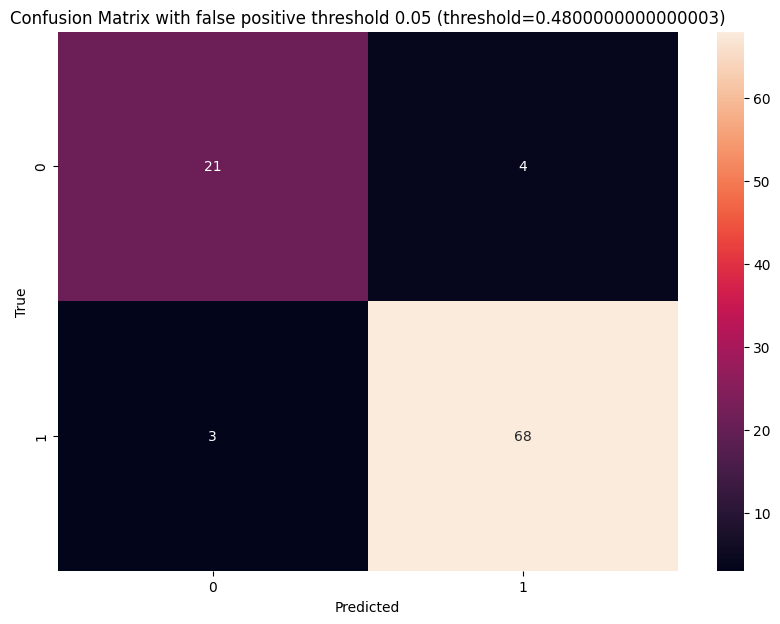

In [32]:
df_all_metrics_copy = df_all_metrics.copy()

# use final answer if confidence 1 > THRESHOLD
THRESHOLD = 0.75
# First we calculate THRESHOLD such that the amount of False Positives is below FP_PERCENTAGE
FP_PERCENTAGE = 0.05

# calculate threshold
THRESHOLD = 0.10
resolution = 0.01
while True:
    df_all_metrics_copy['predicted_use_final_answer'] = df_all_metrics_copy['confidence_1'] > THRESHOLD
    df_all_metrics_copy['predicted_use_final_answer'] = df_all_metrics_copy['predicted_use_final_answer'].astype('int')
    df_all_metrics_copy['use_final_answer'] = df_all_metrics_copy['use_final_answer'].astype('int')
    cm = confusion_matrix(df_all_metrics_copy['use_final_answer'], df_all_metrics_copy['predicted_use_final_answer'])
    fp = cm[0][1]
    if fp / (len(df_all_metrics_copy)) < FP_PERCENTAGE:
        break
    THRESHOLD += resolution
    if (THRESHOLD > 1):
        THRESHOLD = 1
        break

print(THRESHOLD)

df_all_metrics_copy['predicted_use_final_answer'] = df_all_metrics_copy['confidence_1'] > THRESHOLD
df_all_metrics_copy['predicted_use_final_answer'] = df_all_metrics_copy['predicted_use_final_answer'].astype('int')
df_all_metrics_copy['use_final_answer'] = df_all_metrics_copy['use_final_answer'].astype('int')


# confusion matrix
cm = confusion_matrix(df_all_metrics_copy['use_final_answer'], df_all_metrics_copy['predicted_use_final_answer'])
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix with false positive threshold {FP_PERCENTAGE} (threshold={THRESHOLD})')
plt.show()

In the above code, we pick an acceptable percentage of false positives at <5%. We then try out different confidence score thresholds to see which one gives us the desired percentage of false positives. Eventually, we find a threshold of 48%, meaning if the model gives a confidence score of 48% or higher, we accept the answer.

Let's try a percentage of 2% false positives.

0.8300000000000006


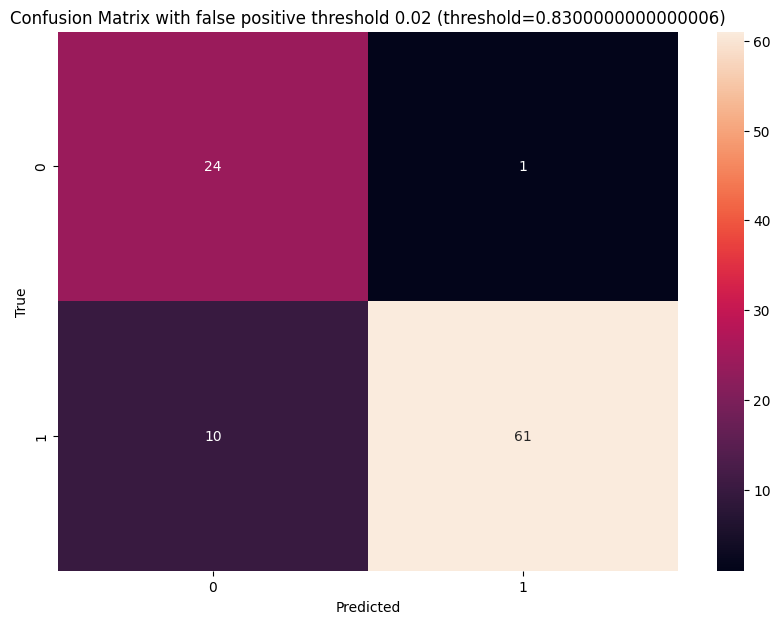

: 

In [35]:
# use final answer if confidence 1 > THRESHOLD
THRESHOLD = 0.75
# First we calculate THRESHOLD such that the amount of False Positives is below FP_PERCENTAGE
FP_PERCENTAGE = 0.02

# calculate threshold
THRESHOLD = 0.10
resolution = 0.01
while True:
    df_all_metrics_copy['predicted_use_final_answer'] = df_all_metrics_copy['confidence_1'] > THRESHOLD
    df_all_metrics_copy['predicted_use_final_answer'] = df_all_metrics_copy['predicted_use_final_answer'].astype('int')
    df_all_metrics_copy['use_final_answer'] = df_all_metrics_copy['use_final_answer'].astype('int')
    cm = confusion_matrix(df_all_metrics_copy['use_final_answer'], df_all_metrics_copy['predicted_use_final_answer'])
    fp = cm[0][1]
    if fp / (len(df_all_metrics_copy)) < FP_PERCENTAGE:
        break
    THRESHOLD += resolution
    if (THRESHOLD > 1):
        THRESHOLD = 1
        break

print(THRESHOLD)

df_all_metrics_copy['predicted_use_final_answer'] = df_all_metrics_copy['confidence_1'] > THRESHOLD
df_all_metrics_copy['predicted_use_final_answer'] = df_all_metrics_copy['predicted_use_final_answer'].astype('int')
df_all_metrics_copy['use_final_answer'] = df_all_metrics_copy['use_final_answer'].astype('int')


# confusion matrix
cm = confusion_matrix(df_all_metrics_copy['use_final_answer'], df_all_metrics_copy['predicted_use_final_answer'])
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix with false positive threshold {FP_PERCENTAGE} (threshold={THRESHOLD})')
plt.show()

From this, we see a threshold of 83% was picked. We see that there are less false positives but a lot more false negatives. This is preferable to false positives however. From this, we can see that there is a trade-off between false positives and false negatives. 

### Validation - Drawbacks
These results are fairly good. However, we should keep in mind this was trained of a small dataset. The model might not generalize well in deployment when different types of forms are used. However, using more data and more varied data, the same approach can likely be used to train a model that generalizes better.

# Conclusion
In this notebook, we explored the extraction of features to train a model to validate answers. We found a selection of features and trained a model. We got fairly good results, albeit using a small dataset. We found that the model can be adjusted to produce less false positive answers at the cost of more false negatives.